# Python Multithreading vs Multiprocessing

This notebook presents examples of application of multithreading and multiprocessing in python, their pros and cons, and the most appropriate case scenarios for each.

Code is based on examples from [Python Documentation](https://docs.python.org/3/library/concurrent.futures.html)


In [1]:
import math
import time
import urllib.request
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

addrs = ['http://www.poatek.com',
        'https://www.poatek.com/team/',
        'https://www.poatek.com/blog/',
        'https://www.poatek.com/our-method/',
        'https://www.poatek.com/services/',
        'https://en.wikipedia.org/wiki/Main_Page',
        'https://www.google.com/',
        'https://www.kaggle.com/competitions',
        'https://www.amazon.com/charts/mostread/fiction/',
        'https://www.amazon.com/charts/mostread/nonfiction',
        'https://www.amazon.com/charts/mostsold/nonfiction',
        'https://www.amazon.com/charts/mostsold/fiction',
        'https://www.nytimes.com',
        'https://www.bbc.com/',
        'https://www.lemonde.fr',
        'https://edition.cnn.com',
        ]

In [2]:
def multithreading(func, args, workers):
    with ThreadPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)


def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)

## Multithreading: I/O intesive tasks

I/O intensive programs can directly benefit from multithreading because their bottlenecks are usually reading and/or writing operations (or downloads in the case of web scrappers, for example).


In this example we will test a function that reads webpages and writes them on a local text file (we forced the file to be re-written a number of times to stress the execution).

In [7]:
def io_intensive(x):
    write_count = 50
    with urllib.request.urlopen(addrs[x], timeout=20) as conn:
        page = conn.read()
        for _ in range(write_count):
            with open('output.txt', 'w') as output:
                output.write(str(page))

def test_io_intensive_threads(thread_count_lst):
    times = []
    num_tasks = len(addrs)
    time_init = time.time()
    for i in range(num_tasks): 
        io_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    for n_threads in thread_count_lst:
        time_init = time.time()
        multithreading(io_intensive, range(num_tasks), n_threads)
        time_end = time.time()
        times.append(float(time_end - time_init))
        print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    return times

Serial execution took 25.204434394836426s.
Multithreading with 2 threads took 11.658916234970093s.
Multithreading with 4 threads took 7.374547004699707s.
Multithreading with 8 threads took 4.76583194732666s.
Multithreading with 16 threads took 3.586735963821411s.


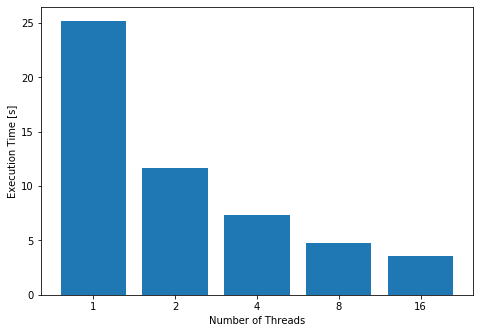

In [14]:
times = test_io_intensive_threads([2, 4, 8, 16])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Execution Time [s]')
num_threads = ['1', '2', '4', '8', '16']
ax.bar(num_threads, times)
plt.show()

---
Expected result from a Macbook Air 2019: <br>
``
Serial execution took 23.027223110198975s.
Multithreading with 2 threads took 11.409204006195068s.
Multithreading with 4 threads took 7.340421199798584s.
Multithreading with 8 threads took 6.104223966598511s.
Multithreading with 16 threads took 4.301616907119751s.
``

---

If your internet connection is alright you should notice that we were able to reduce considerably the execution time of that code.

## Multiprocessing: CPU-intesive tasks

Programs that are CPU-bound will benefit from multiprocessing because their bottleneck is time and resources. Image and graphics processing are good examples, as they consist of huge amounts of math operations, that can often be divided into separate tasks because their data is independent. GPUs are the state-of-the-art hardware on this regard, being designed to process large chunks of data in parallel. 


In [5]:
def compute_intensive(x):
    foo = 0
    for i in range(10**7):
        foo += foo * math.cos(i*math.pi)
        
def test_compute_intensive():
    num_tasks = 4
    time_init = time.time()
    for i in range(num_tasks): 
        compute_intensive(i)
    time_end = time.time()
    print(f'Serial execution took {time_end - time_init}s.')
    n_threads = num_tasks
    time_init = time.time()
    multithreading(compute_intensive, range(num_tasks), n_threads)
    time_end = time.time()
    print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    n_procs = num_tasks
    time_init = time.time()
    multiprocessing(compute_intensive, range(num_tasks), n_procs)
    time_end = time.time()
    print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')

In [6]:
test_compute_intensive()

Serial execution took 10.285893201828003s.
Multithreading with 4 threads took 9.91785717010498s.
Multiprocessing with 4 processes took 6.127450704574585s.


---
Expected result from a Macbook Air 2019: <br>
``
Serial execution took 9.491488933563232s.
Multithreading with 4 threads took 10.261078119277954s.
Multiprocessing with 4 processes took 6.33841609954834s.
``

---

It shall be clear from this example that multithreading just not able to achieve any speedup for this type of application.
That is because GIL assures only one thread is executed in the CPU at a given time.

## Multiprocessing on I/O intensive functions

We have not tested multiprocessing on I/O intesive functions. Even thougt it is, in theory, a waste of resources to dedicate a process to a I/O-bound task, there should be no reason for multiprocessing to be unable to achieve speedups in this use case.

Let's check it out:


In [12]:
def test_io_intensive_processes(proc_count_lst):
    times = []
    num_tasks = len(addrs)
    time_init = time.time()
    for i in range(num_tasks): 
        io_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    for n_procs in proc_count_lst:
        time_init = time.time()
        multiprocessing(io_intensive, range(num_tasks), n_procs)
        time_end = time.time()
        times.append(float(time_end - time_init))
        print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')
    return times

Serial execution took 25.208795070648193s.
Multiprocessing with 2 processes took 10.804198980331421s.
Multiprocessing with 4 processes took 7.33573579788208s.
Multiprocessing with 8 processes took 3.606238842010498s.


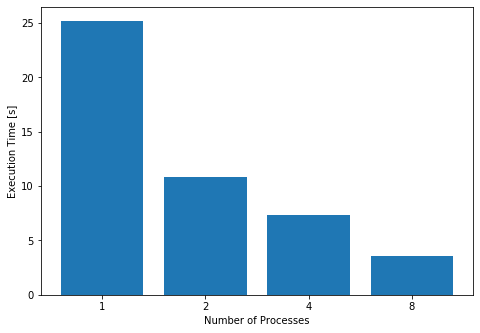

In [15]:
times = test_io_intensive_processes([2, 4, 8])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Processes')
ax.set_ylabel('Execution Time [s]')
num_threads = ['1', '2', '4', '8']
ax.bar(num_threads, times)
plt.show()

---
Expected result from a Macbook Air 2019: <br>
``
Serial execution took 24.917934894561768s.
Multiprocessing with 2 processes took 10.67212700843811s.
Multiprocessing with 4 processes took 7.214836835861206s.
Multiprocessing with 8 processes took 6.2057600021362305s.
``

---

As expected, multiprocessing could also deliver speedup for an IO-bound task. You may however notice that threads are still the best option for that case. That is because proccesses have a much higher initialization cost that may compromise their performance. Also, as discussed before, the number of process you can have execution in parallel is limited by the number of processing cores of the machine you are using.